In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns
import matplotlib.pyplot as plt
import shutil

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import DenseNet121
from keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout, Dense
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau



In [ ]:
print(tf.__version__)
print(keras.__version__)

2.15.0
2.15.0


In [ ]:
Data_path = '/content/drive/MyDrive/Paper/Data'

# List all the labels and the number of images in each label
image_labels = sorted(os.listdir(Data_path))
num_classes = len(image_labels)
print("Number of classes:", num_classes)

print(image_labels)
for label in image_labels:
    print('{}: {} images'.format(label, len(os.listdir(Data_path + '/' + label))))



Number of classes: 3
['metal', 'paper', 'plastic']
metal: 960 images
paper: 970 images
plastic: 1050 images


In [ ]:
def read_image(image_path):
    image = []
    labels = []

    for label, class_name in enumerate(os.listdir(image_path)):
        for image_name in os.listdir(os.path.join(image_path, class_name)):
            img = cv2.imread(os.path.join(image_path, class_name, image_name))
            img = cv2.resize(img, (224, 224), interpolation = cv2.INTER_LINEAR_EXACT)
            image.append(img)
            labels.append(label)

    return image, labels
def one_hot_encoding(image,labels):
    image = np.array(image, dtype='float32') / 255.0
    LB = LabelBinarizer()
    labels = LB.fit_transform(np.array(labels))
    return image, labels

def split_data(image, labels, val_ratio, test_ratio):
    # Split the dataset into train, validation, and test sets
    train_images, val_test_images, train_labels, val_test_labels = train_test_split(image, labels, test_size=val_ratio+test_ratio, shuffle=True, random_state=42)
    val_images, test_images, val_labels, test_labels = train_test_split(val_test_images, val_test_labels, test_size=(test_ratio/(val_ratio+test_ratio)), shuffle=True, random_state=42)
    return train_images, val_images, test_images, train_labels, val_labels, test_labels



In [ ]:
def plot_train_result(history):
    Accuracy = history.history['accuracy']
    Val_accuracy = history.history['val_accuracy']
    Loss = history.history['loss']
    Val_loss = history.history['val_loss']
    #Lr = history.history['lr']
    Epochs = range(1, len(Accuracy) + 1)

    fig, axes = plt.subplots(1, 2, figsize = (15, 5))

    axes[0].plot(Epochs, Accuracy, 'r', label = 'Training accuracy')
    axes[0].plot(Epochs, Val_accuracy, 'g', label = 'Validation accuracy')
    axes[0].set_title('Training and validation accuracy')
    axes[0].legend(loc = 'lower right')
    axes[0].set_xlabel('Epoch', fontsize = 16)
    axes[0].set_ylabel('Accuracy', fontsize = 16)

    axes[1].plot(Epochs, Loss, 'r', label = 'Training loss')
    axes[1].plot(Epochs, Val_loss, 'g', label = 'Validation loss')
    axes[1].set_title('Training and validation loss')
    axes[1].legend(loc = 'upper right')
    axes[1].set_xlabel('Epoch', fontsize = 16)
    axes[1].set_ylabel('Loss', fontsize = 16)

    #axes[2].plot(Epochs, Lr, 'b')
    #axes[2].set_title('Reduce Learning Rate on Plateau')
    #axes[2].set_xlabel('Epoch', fontsize = 16)
    #axes[2].set_ylabel('Learning rate', fontsize = 16)

    plt.tight_layout()
    plt.show()

In [ ]:

def test_result(image_predictions, test_labels):
    y_true = np.argmax(test_labels, axis=1)
    y_pred = np.argmax(image_predictions, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    clr = classification_report(y_true, y_pred)

    print('Confusion Matrix:')
    print(cm)
    print('\nClassification Report:')
    print(clr)

    accuracy = np.sum(y_true == y_pred) / len(y_true)
    print('\nTest Accuracy:', round(accuracy * 100, 2), '%')

In [ ]:
# Read the dataset
images, labels = read_image(Data_path)

# Perform one-hot encoding
images, labels = one_hot_encoding(images, labels)

# Split the data into train, validation, and test sets
train_images, val_images, test_images, train_labels, val_labels, test_labels = split_data(images, labels, val_ratio=0.151, test_ratio=0.151)


In [ ]:
train_aug = ImageDataGenerator(rotation_range=180,
                               zoom_range=0.3,
                               horizontal_flip=True,
                               vertical_flip =True )
val_aug = ImageDataGenerator()

In [ ]:

# Load the InceptionV3 model
base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# Train the model
history = model.fit(train_aug.flow(train_images, train_labels, batch_size=32),
                    steps_per_epoch=len(train_images) // 32,
                    validation_data=val_aug.flow(val_images, val_labels, batch_size=32),
                    validation_steps=len(val_images) // 32,
                    epochs=20,
                    callbacks=[checkpoint, reduce_lr])

87910968/87910968 [==============================] - 3s 0us/step


Epoch 1/20
65/65 [==============================] - ETA: 0s - loss: 0.9306 - accuracy: 0.7524
Epoch 1: val_loss improved from inf to 0.40606, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


65/65 [==============================] - 48s 509ms/step - loss: 0.9306 - accuracy: 0.7524 - val_loss: 0.4061 - val_accuracy: 0.8638 - lr: 0.0010
Epoch 2/20
65/65 [==============================] - ETA: 0s - loss: 0.5670 - accuracy: 0.8394
Epoch 2: val_loss improved from 0.40606 to 0.29195, saving model to model.h5
65/65 [==============================] - 27s 418ms/step - loss: 0.5670 - accuracy: 0.8394 - val_loss: 0.2919 - val_accuracy: 0.8862 - lr: 0.0010
Epoch 3/20
65/65 [==============================] - ETA: 0s - loss: 0.4829 - accuracy: 0.8481
Epoch 3: val_loss did not improve from 0.29195
65/65 [==============================] - 27s 411ms/step - loss: 0.4829 - accuracy: 0.8481 - val_loss: 0.3136 - val_accuracy: 0.8906 - lr: 0.0010
Epoch 4/20
65/65 [==============================] - ETA: 0s - loss: 0.4910 - accuracy: 0.8351
Epoch 4: val_loss did not improve from 0.29195
65/65 [==============================] - 27s 419ms/step - loss: 0.4910 - accuracy: 0.8351 - val_loss: 0.3082 - v

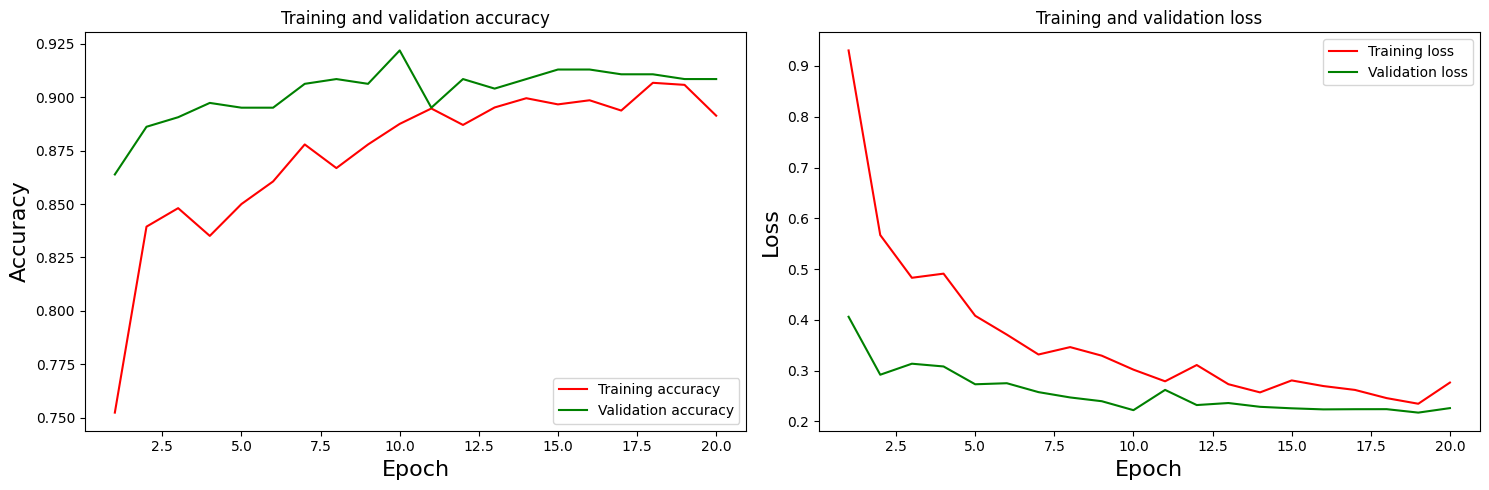

In [ ]:
plot_train_result(history)

In [ ]:
# Load the best model
model.load_weights('/content/model.h5')

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=1)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

# Make predictions on the test set
image_predictions = model.predict(test_images)

# Plot the test result
test_result(image_predictions, test_labels)

15/15 [==============================] - 1s 69ms/step - loss: 0.2059 - accuracy: 0.9200
Test Loss: 0.20588992536067963
Test Accuracy: 0.9200000166893005
15/15 [==============================] - 1s 65ms/step
Confusion Matrix:
[[135   6  14]
 [  1 133   3]
 [ 11   1 146]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.87      0.89       155
           1       0.95      0.97      0.96       137
           2       0.90      0.92      0.91       158

    accuracy                           0.92       450
   macro avg       0.92      0.92      0.92       450
weighted avg       0.92      0.92      0.92       450


Test Accuracy: 92.0 %


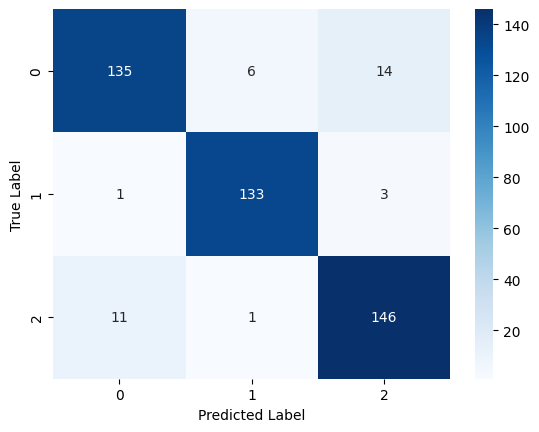

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Your confusion matrix data
data = [[135 , 6 , 14],
 [ 1, 133, 3],
 [ 11, 1, 146]]

# Plot the heatmap directly from the data
sns.heatmap(data, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()